In [1]:
#install.packages()
library(R.matlab)
library(survival)
library(reticulate)

base.path <- '/sbgenomics/workspace/sleep-outcome-prediction'
source(file.path(base.path, 'Rfunctions.R'))

R.matlab v3.7.0 (2022-08-25 21:52:34 UTC) successfully loaded. See ?R.matlab for help.


Attaching package: ‘R.matlab’


The following objects are masked from ‘package:base’:

    getOption, isOpen




In [2]:
model <- readRDS(file.path(base.path, 'models/model_Dementia_CoxPH_CompetingRisk.rda'))
results <- readMat(file.path(base.path, 'models/results_Dementia_CoxPH_CompetingRisk.mat'))

In [3]:
df <- read.csv(file.path(base.path, 'to_be_used_features_NREM_deid.csv'))
idx <- 2
df <- df[idx,]

In [4]:
cols <- unlist(results$Xmean.names)
Xmean <- results$Xmean
Xstd <- results$Xstd
df[,cols] <- ( df[,cols]-t(replicate(nrow(df), Xmean)) ) / t(replicate(nrow(df), Xstd))

stopifnot(sum(is.na(df))==0)

In [5]:
pred1 <- summary(survfit(model[[1]], df))
pred2 <- summary(survfit(model[[2]], df))
pred3 <- summary(survfit(model[[3]], df))

pred1 <- list(time=pred1$time, val=pred1$pstate, state=pred1$states)
pred2 <- list(time=pred2$time, val=pred2$pstate, state=pred2$states)
pred3 <- list(time=pred3$time, val=pred3$pstate, state=pred3$states)

pred <- harmonize.curves2(list(pred1, pred2, pred3))
state.idx <- which(pred$states=='event1')
pred$val <- apply(pred$val, c(1,3,4), mean, na.rm=TRUE)[,,state.idx]

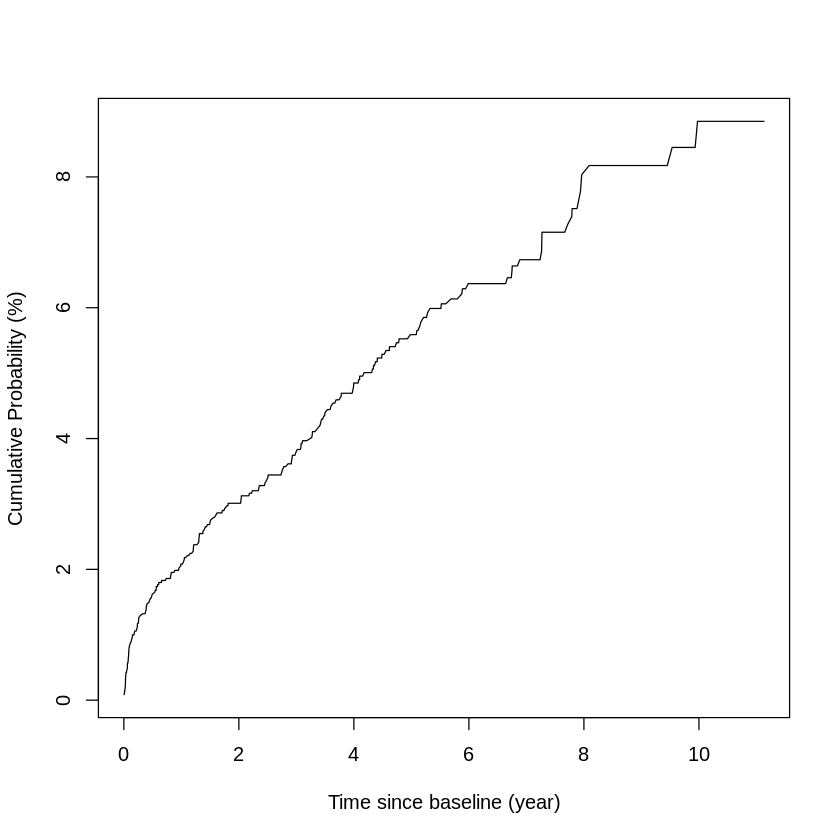

In [6]:
plot(
    pred$time, pred$val*100, type='l',
    xlab='Time since baseline (year)', ylab='Cumulative Probability (%)'
)